In [1]:
import h5py as h5
import numpy as np
import astropy.units as u
import matplotlib.pyplot as plt
import seaborn as sns
import legwork

from matplotlib.ticker import FixedLocator
from matplotlib.lines import Line2D

import sys
sys.path.append("../../simulation/src/")
from variations import variations
from galaxy import simulate_mw

import bootstrap as boots

%config InlineBackend.figure_format = 'retina'
plt.rc('font', family='serif')
fs = 20

params = {'legend.fontsize': fs,
         'axes.labelsize': fs,
         'xtick.labelsize':0.7*fs,
         'ytick.labelsize':0.7*fs}
plt.rcParams.update(params)

In [2]:
dco_colours = {"BHBH": plt.get_cmap("plasma")(0.2),
               "BHNS": plt.get_cmap("plasma")(0.5),
               "NSNS": plt.get_cmap("plasma")(0.8)}

dco_types = ["BHBH", "BHNS", "NSNS"]
sim_folder = "../../simulation/data/simulation/"

total_DCOs_in_MW = np.load("../../simulation/data/total_DCO_in_MW.npy")

detections = np.load("../../simulation/data/detections_4yr.npy")
detections_10yr = np.load("../../simulation/data/detections_10yr.npy")

In [3]:
""" helper function for setting log spaced ticks """
def get_log_ticks(min_log, max_log):
    
    bottom = np.floor(min_log).astype(int)
    top = np.ceil(max_log).astype(int)
    
    ticks = []
    
    for i in range(bottom, top + 1):
        for j in range(2, 10):
            log_tick = np.log10(j * 10**(i))
            if log_tick > bottom and log_tick < top:
                ticks.append(log_tick)
                
    return ticks

Fiducial
Plotting mass for BHBH
Plotting mass for BHNS
Fryer rapid SN remnant mass prescription
Plotting mass for BHBH
Plotting mass for BHNS


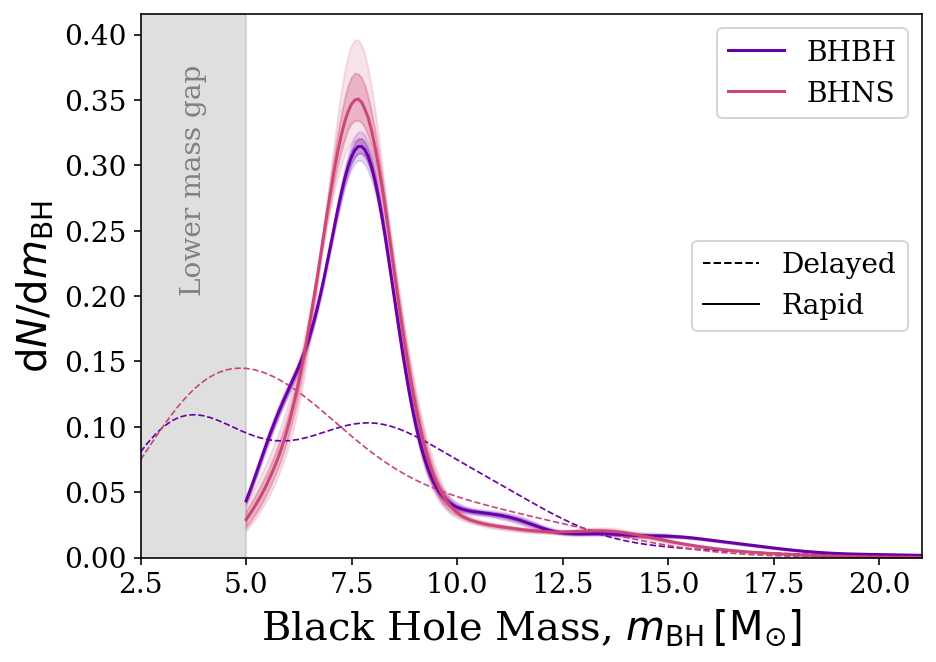

In [119]:
fig, ax = plt.subplots(figsize=(7, 5))
lw = 4
    
for model, style in [(0, "--"), (11, "-")]:
    print(variations[model]["long"])
    if model == 0:
        bootstraps = None
    else:
        bootstraps = 200

    for i, dco_type in enumerate(["BHBH", "BHNS"]):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()
            
        # work out which masses are the BH and NS masses
        if dco_type == "BHNS":
            mBH = np.maximum(data["m_1"], data["m_2"])
            mass_weights = data["weight"]
            mass_seeds = data["seed"]
        elif dco_type == "BHBH":
            mBH = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))

        # plot the distance distribution
        print("Plotting mass for", dco_type)
        if bootstraps is not None:
            ax = boots.bootstrapped_kde(mBH, mass_weights, mass_seeds, bw_adjust=1.4,
                                                    ax=ax, color=dco_colours[dco_type], label=dco_type,
                                                    bootstraps=bootstraps, lower_bound=0.0, x_min=5, x_max=21)
        else:
            sorted_order = np.argsort(mass_seeds)
            sorted_seeds = mass_seeds[sorted_order]
            _, starts, counts = np.unique(sorted_seeds, return_counts=True, return_index=True)
            res = np.split(sorted_order, starts[1:])
            inds = np.array([np.random.choice(r) if len(r) > 1 else r[0] for r in res])
            ax.plot(*boots.kde(mBH[inds], weights=mass_weights[inds] * counts, lower_bound=0.0, bw_adjust=1.4, x_min=2.5),
                                color=dco_colours[dco_type], linestyle=style, lw=0.85)
            
ax.axvspan(2.5, 5.0, color="grey", alpha=0.25)
ax.annotate("Lower mass gap", xy=(3.75, 0.2), color="grey", rotation=90, ha="center", va="bottom", fontsize=0.7*fs)

ax.set_xlabel(r"Black Hole Mass, $m_{\rm BH} \, [\rm M_{\odot}]$")
ax.set_xlim(2.5, 21)

ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d} m_{\rm BH}$")


first_legend = plt.legend(loc='upper right', fontsize=0.7 * fs)
ax.add_artist(first_legend)

# Create another legend for the second line.
custom_lines = [Line2D([0], [0], color="black", lw=1, linestyle="--"),
                Line2D([0], [0], color="black", lw=1)]
ax.legend(handles=custom_lines, labels=["Delayed", "Rapid"],
          loc='center right', fontsize=0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(bottom=0.0)

plt.savefig("../figures/mBH_rapid_variation.pdf", format="pdf", bbox_inches="tight")

plt.show()

Plotting eccentricity for BHBH
Plotting eccentricity for BHNS
Plotting eccentricity for NSNS
Plotting eccentricity for BHBH
Plotting eccentricity for BHNS
Plotting eccentricity for NSNS


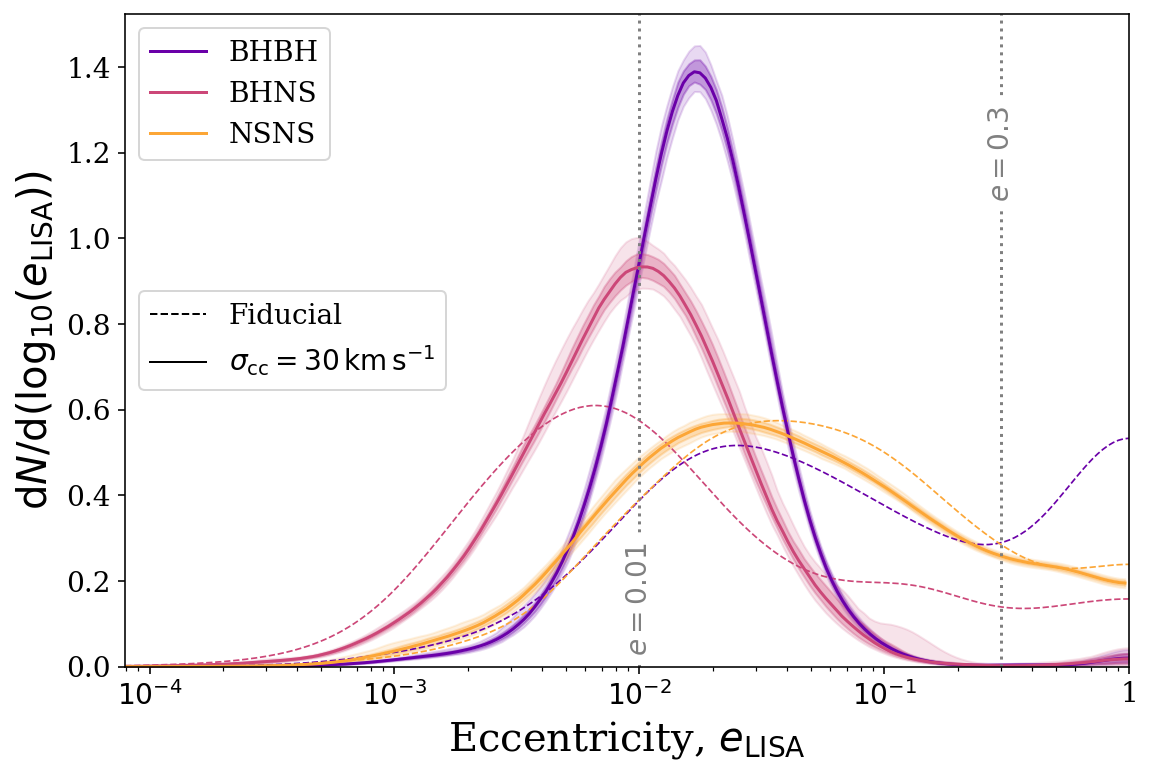

In [118]:
fig, ax = plt.subplots(figsize=(9, 6))
lw = 4
    
for model, style in [(0, "--"), (16, "-")]:
    if model == 0:
        bootstraps = None
    else:
        bootstraps = 200

    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()

        # plot the distance distribution
        print("Plotting eccentricity for", dco_type)
        if bootstraps is not None:
            ax = boots.bootstrapped_kde(np.log10(data["e_LISA"]), data["weight"], data["seed"], ax=ax, color=dco_colours[dco_type],
                                        label=dco_type, bootstraps=bootstraps, upper_bound=0.0, bw_adjust=1.5)
        else:
            sorted_order = np.argsort(data["seed"])
            sorted_seeds = data["seed"][sorted_order]
            _, starts, counts = np.unique(sorted_seeds, return_counts=True, return_index=True)
            res = np.split(sorted_order, starts[1:])
            inds = np.array([np.random.choice(r) if len(r) > 1 else r[0] for r in res])
            ax.plot(*boots.kde(np.log10(data["e_LISA"][inds]), weights=data["weight"][inds] * counts, upper_bound=0.0, bw_adjust=1.5),
                    color=dco_colours[dco_type], linestyle=style, lw=0.85)

ax.set_xlabel(r"Eccentricity, $e_{\rm LISA}$")
ax.set_xlim(-4.1, 0)
ax.set_xticks([-4, -3, -2, -1, 0])
ax.set_xticklabels([r"$10^{-4}$", r"$10^{-3}$", r"$10^{-2}$", r"$10^{-1}$", "1"])
ax.xaxis.set_minor_locator(FixedLocator(get_log_ticks(*ax.get_xlim())))
ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d}(\log_{10} (e_{\rm LISA}))$")


first_legend = plt.legend(loc='upper left', fontsize=0.7 * fs)
ax.add_artist(first_legend)

# Create another legend for the second line.
custom_lines = [Line2D([0], [0], color="black", lw=1, linestyle="--"),
                Line2D([0], [0], color="black", lw=1)]
ax.legend(handles=custom_lines, labels=["Fiducial", r"$\sigma_{\rm cc} = 30 \, \rm{km \, s^{-1}}$"],
          loc='center left', fontsize=0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(bottom=0.0)

for e in [0.01, 0.3]:
    ax.axvline(np.log10(e), color="grey", linestyle="dotted")
    ax.annotate(r"$e = {{{}}}$".format(e), xy=(np.log10(e), 0.04 if e < 0.1 else 1.1), color="grey",
                        bbox=dict(boxstyle="round", ec="white", fc="white"), ha="center", rotation=90, fontsize=0.7*fs, zorder=2)

plt.savefig("../figures/ecc_low_kick_variation.pdf", format="pdf", bbox_inches="tight")

plt.show()

Fiducial
Plotting tau for BHBH
Plotting tau for BHNS
Plotting tau for NSNS
CE efficiency $\alpha = 2.0$
Plotting tau for BHBH
Plotting tau for BHNS
Plotting tau for NSNS


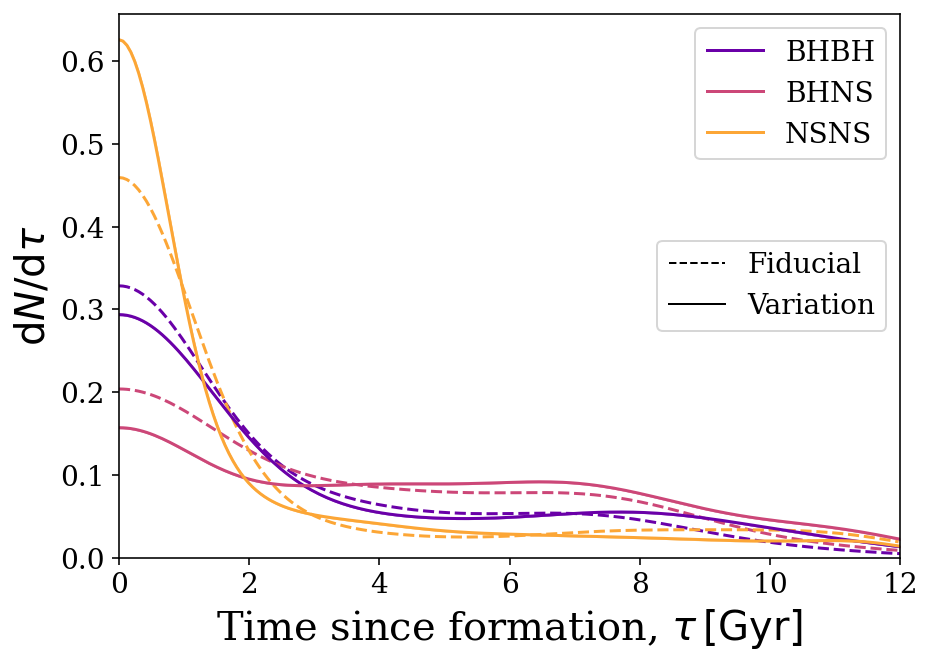

In [115]:
fig, ax = plt.subplots(figsize=(7, 5))
lw = 4

bootstraps = None
    
for model, style in [(0, "--"), (8, "-")]:
    print(variations[model]["long"])
    if model == 0:
        bootstraps = None
    else:
        bootstraps = 1

    for i, dco_type in enumerate(dco_types):
        # open corresponding COMPAS file
        with h5.File(sim_folder + "{}_{}_all.h5".format(dco_type, variations[model]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()

        # plot the distance distribution
        print("Plotting tau for", dco_type)
        if bootstraps is not None:
            ax = boots.bootstrapped_kde(data["tau"], data["weight"], data["seed"],
                                          ax=ax, color=dco_colours[dco_type], label=dco_type,
                                          bootstraps=bootstraps, lower_bound=0.0, bw_adjust=1.5)
        else:
            sorted_order = np.argsort(data["seed"])
            sorted_seeds = data["seed"][sorted_order]
            _, starts, counts = np.unique(sorted_seeds, return_counts=True, return_index=True)
            res = np.split(sorted_order, starts[1:])
            inds = np.array([np.random.choice(r) if len(r) > 1 else r[0] for r in res])
            ax.plot(*boots.kde(data["tau"][inds], weights=data["weight"][inds] * counts, lower_bound=0.0, bw_adjust=1.5),
                            color=dco_colours[dco_type], linestyle=style)
            
ax.set_xlabel(r"Time since formation, $\tau \, [\rm Gyr]$")
ax.set_xlim(0, 12)
ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d}\tau$")


first_legend = plt.legend(loc='upper right', fontsize=0.7 * fs)
ax.add_artist(first_legend)

# Create another legend for the second line.
custom_lines = [Line2D([0], [0], color="black", lw=1, linestyle="--"),
                Line2D([0], [0], color="black", lw=1)]
ax.legend(handles=custom_lines, labels=["Fiducial", "Variation"],
          loc='center right', fontsize=0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(bottom=0.0)

# plt.savefig("../figures/mBH_rapid_variation.pdf", format="pdf", bbox_inches="tight")

plt.show()

# Simple Milky Way stuff

../../simulation/data/simple_mw_simulation/simple_mw_
Plotting mass for BHBH
Plotting mass for BHNS
../../simulation/data/simulation/
Plotting mass for BHBH
Plotting mass for BHNS


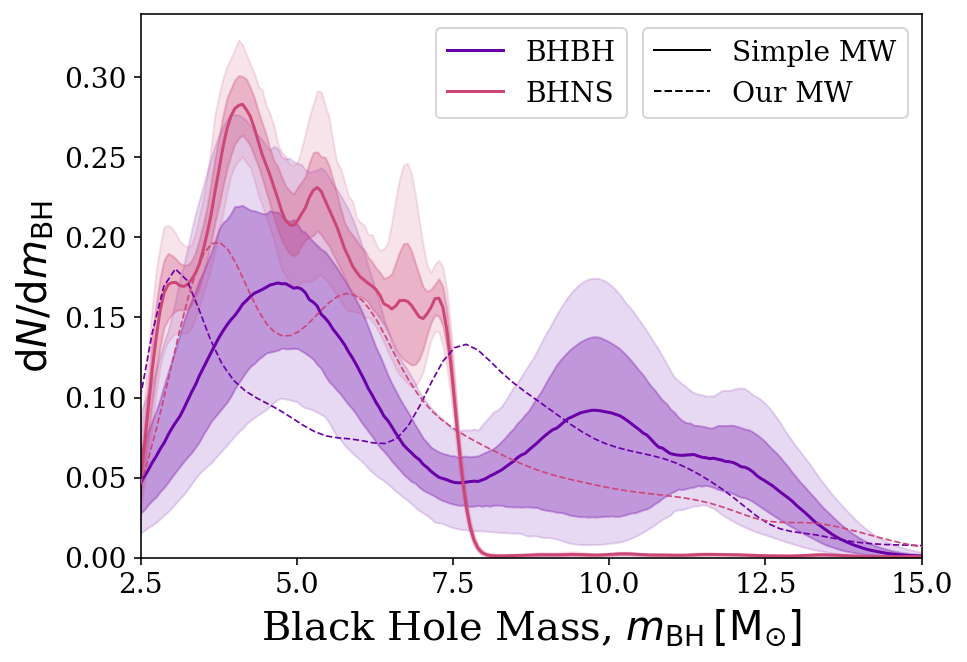

In [36]:
fig, ax = plt.subplots(figsize=(7, 5))
lw = 4
    
for folder, style in [("../../simulation/data/simple_mw_simulation/simple_mw_", "-"), (sim_folder, "--")]:
    print(folder)
    if folder == sim_folder:
        bootstraps = None
    else:
        bootstraps = 200

    for i, dco_type in enumerate(["BHBH", "BHNS"]):
        # open corresponding COMPAS file
        with h5.File(folder + "{}_{}_all.h5".format(dco_type, variations[0]["file"]), "r") as f:
            data = f["simulation"][...].squeeze()
            
        # work out which masses are the BH and NS masses
        if dco_type == "BHNS":
            mBH = np.maximum(data["m_1"], data["m_2"])
            mass_weights = data["weight"]
            mass_seeds = data["seed"]
        elif dco_type == "BHBH":
            mBH = np.concatenate((data["m_1"], data["m_2"]))
            mass_weights = np.concatenate((data["weight"], data["weight"]))
            mass_seeds = np.concatenate((data["seed"], -1 * data["seed"]))

        # plot the distance distribution
        print("Plotting mass for", dco_type)
        bw_adjust = 0.5
        if bootstraps is not None:
            ax = boots.bootstrapped_kde(mBH, mass_weights, mass_seeds, bw_adjust=bw_adjust,
                                                    ax=ax, color=dco_colours[dco_type], label=dco_type,
                                                    bootstraps=bootstraps, lower_bound=0.0, x_min=2.5, x_max=15)
        else:
            sorted_order = np.argsort(mass_seeds)
            sorted_seeds = mass_seeds[sorted_order]
            _, starts, counts = np.unique(sorted_seeds, return_counts=True, return_index=True)
            res = np.split(sorted_order, starts[1:])
            inds = np.array([np.random.choice(r) if len(r) > 1 else r[0] for r in res])
            ax.plot(*boots.kde(mBH[inds], weights=mass_weights[inds] * counts, lower_bound=0.0, bw_adjust=bw_adjust, x_min=2.5),
                                color=dco_colours[dco_type], linestyle=style, lw=0.85, zorder=10)

ax.set_xlabel(r"Black Hole Mass, $m_{\rm BH} \, [\rm M_{\odot}]$")
ax.set_xlim(2.5, 15)
ax.set_xticks([2.5, 5, 7.5, 10, 12.5, 15])

ax.set_ylabel(r"$\mathrm{d}N / \mathrm{d} m_{\rm BH}$")


first_legend = plt.legend(loc='upper center', fontsize=0.7 * fs)
ax.add_artist(first_legend)

# Create another legend for the second line.
custom_lines = [Line2D([0], [0], color="black", lw=1),
                Line2D([0], [0], color="black", lw=1, linestyle="--")]
ax.legend(handles=custom_lines, labels=["Simple MW", "Our MW"],
          loc='upper right', fontsize=0.7*fs)

ax.tick_params(labelsize=0.7*fs)
ax.xaxis.label.set_fontsize(fs)

ax.set_ylim(bottom=0.0)

plt.savefig("../figures/mBH_simple_mw_variation.pdf", format="pdf", bbox_inches="tight")

plt.show()